In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

import os
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
path2data = './data'
os.makedirs(path2data, exist_ok=True) # 폴더 생성

In [4]:
train_ds = datasets.MNIST(path2data, train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]), download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


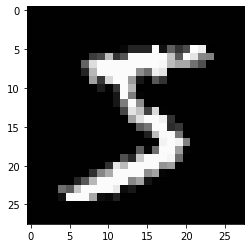

In [5]:
# 샘플 이미지 확인
img, label = train_ds[0]
plt.imshow(to_pil_image(img),cmap='gray')

In [6]:
# 데이터 로더 생성
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

# check
for x, y in train_dl:
    print(x.shape, y.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [12]:
# Generator는 Noise이미지를 입력받아, 이미지를 생성하는 역할을 합니다.

class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.nz = params['nz']  # input Noise Vevtor
        self.img_size = params['img_size']
        
        self.model = nn.Sequential(
            *self._fc_layer(self.nz, 128, normalize = False),
            *self._fc_layer(128, 256),
            *self._fc_layer(256, 512),
            *self._fc_layer(512, 1024),
            # prod는 곱을 의미합니다. 1*28*28 = 784
            nn.Linear(1024, int(np.prod(self.img_size))),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_size)
        return img
    
    def _fc_layer(self, in_channels, out_channels, normalize = True):
        layers = []
        layers.append(nn.Linear(in_channels, out_channels))
        if normalize:
            layers.append(nn.BatchNorm1d(out_channels, 0.8))
        
        layers.append(nn.LeakyReLU(0.2))
        return layers

In [13]:
params = {'nz' : 100,
          'img_size' : (1, 28, 28)}

x = torch.randn(16, 100).to(device)
model_gen = Generator(params).to(device)
output = model_gen(x) # noise를 입력받아 이미지 생성
print(output.shape)

torch.Size([16, 1, 28, 28])


In [14]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.img_size = params['img_size']
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_size)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

x = torch.randn(16, 1, 28, 28).to(device)
model_dis = Discriminator(params).to(device)
output = model_dis(x)
print(output.shape)

torch.Size([16, 1])


In [16]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [17]:
# 손실 함수
loss_func = nn.BCELoss()

from torch import optim

# 최적화 파라미터
lr = 2e-4
beta1 = 0.5

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,0.999))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,0.999))

In [19]:
real_label = 1.
fake_label = 0.
nz = params['nz']
num_epochs = 300

loss_history={'gen':[],
              'dis':[]}

In [22]:
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.size(0)
        xb = xb.to(device)
        yb_real = torch.Tensor(ba_si, 1).fill_(1.0).to(device)
        yb_fake = torch.Tensor(ba_si, 1).fill_(0.0).to(device)
        
        # Generator
        model_gen.zero_grad()
        noise = torch.randn(ba_si, nz, device = device)
        out_gen = model_gen(noise)  # 가짜 이미지 생성
        out_dis = model_dis(out_gen)  # 가짜 이미지 판별
        
        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()
        
        model_dis.zero_grad()
        
        out_real = model_dis(xb)
        out_fake = model_dis(out_gen.detach())
        loss_real = loss_func(out_real, yb_real)
        loss_fake = loss_func(out_fake, yb_fake)
        loss_dis = (loss_real + loss_fake) / 2
        
        loss_dis.backward()
        opt_dis.step()
        
        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())
        
        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))

Epoch: 1, G_Loss: 1.228217, D_Loss: 0.358905, time: 0.19 min
Epoch: 2, G_Loss: 0.879984, D_Loss: 0.369592, time: 0.37 min
Epoch: 3, G_Loss: 1.500987, D_Loss: 0.239487, time: 0.56 min
Epoch: 4, G_Loss: 1.721232, D_Loss: 0.272989, time: 0.74 min
Epoch: 5, G_Loss: 1.400130, D_Loss: 0.221953, time: 0.93 min
Epoch: 6, G_Loss: 3.220726, D_Loss: 0.266584, time: 1.11 min
Epoch: 7, G_Loss: 0.888644, D_Loss: 0.348930, time: 1.30 min
Epoch: 8, G_Loss: 1.458319, D_Loss: 0.211361, time: 1.49 min
Epoch: 9, G_Loss: 2.297022, D_Loss: 0.136782, time: 1.67 min
Epoch: 10, G_Loss: 1.787906, D_Loss: 0.173484, time: 1.86 min
Epoch: 11, G_Loss: 2.468176, D_Loss: 0.161331, time: 2.04 min
Epoch: 12, G_Loss: 2.476079, D_Loss: 0.208641, time: 2.23 min
Epoch: 13, G_Loss: 1.706085, D_Loss: 0.166675, time: 2.42 min
Epoch: 14, G_Loss: 1.870277, D_Loss: 0.230256, time: 2.61 min
Epoch: 15, G_Loss: 3.911292, D_Loss: 0.088488, time: 2.79 min
Epoch: 17, G_Loss: 2.025027, D_Loss: 0.223186, time: 2.98 min
Epoch: 18, G_Loss

Epoch: 140, G_Loss: 2.255023, D_Loss: 0.134340, time: 24.19 min
Epoch: 141, G_Loss: 1.670558, D_Loss: 0.267076, time: 24.37 min
Epoch: 142, G_Loss: 2.393305, D_Loss: 0.196741, time: 24.55 min
Epoch: 143, G_Loss: 3.621790, D_Loss: 0.149253, time: 24.73 min
Epoch: 144, G_Loss: 3.120784, D_Loss: 0.213187, time: 24.91 min
Epoch: 146, G_Loss: 3.033519, D_Loss: 0.127878, time: 25.09 min
Epoch: 147, G_Loss: 3.354189, D_Loss: 0.273345, time: 25.28 min
Epoch: 148, G_Loss: 3.228151, D_Loss: 0.217085, time: 25.46 min
Epoch: 149, G_Loss: 4.026707, D_Loss: 0.133853, time: 25.64 min
Epoch: 150, G_Loss: 2.876618, D_Loss: 0.150724, time: 25.83 min
Epoch: 151, G_Loss: 3.755374, D_Loss: 0.224413, time: 26.01 min
Epoch: 152, G_Loss: 4.719137, D_Loss: 0.370377, time: 26.20 min
Epoch: 153, G_Loss: 2.300195, D_Loss: 0.181374, time: 26.38 min
Epoch: 154, G_Loss: 2.697819, D_Loss: 0.182344, time: 26.56 min
Epoch: 155, G_Loss: 3.482620, D_Loss: 0.115999, time: 26.75 min
Epoch: 156, G_Loss: 3.929637, D_Loss: 0.

Epoch: 278, G_Loss: 2.855769, D_Loss: 0.149771, time: 47.75 min
Epoch: 279, G_Loss: 2.914969, D_Loss: 0.142521, time: 47.94 min
Epoch: 280, G_Loss: 4.718407, D_Loss: 0.155954, time: 48.12 min
Epoch: 281, G_Loss: 2.542196, D_Loss: 0.208643, time: 48.31 min
Epoch: 282, G_Loss: 3.326223, D_Loss: 0.158181, time: 48.49 min
Epoch: 283, G_Loss: 3.401133, D_Loss: 0.090078, time: 48.68 min
Epoch: 284, G_Loss: 2.806655, D_Loss: 0.178692, time: 48.86 min
Epoch: 285, G_Loss: 3.386417, D_Loss: 0.116948, time: 49.05 min
Epoch: 286, G_Loss: 3.026511, D_Loss: 0.149740, time: 49.23 min
Epoch: 287, G_Loss: 2.852320, D_Loss: 0.168144, time: 49.42 min
Epoch: 288, G_Loss: 4.311176, D_Loss: 0.110021, time: 49.60 min
Epoch: 289, G_Loss: 2.976110, D_Loss: 0.115369, time: 49.79 min
Epoch: 291, G_Loss: 2.502585, D_Loss: 0.120359, time: 49.98 min
Epoch: 292, G_Loss: 3.658727, D_Loss: 0.211244, time: 50.16 min
Epoch: 293, G_Loss: 3.176110, D_Loss: 0.238833, time: 50.34 min
Epoch: 294, G_Loss: 3.781991, D_Loss: 0.

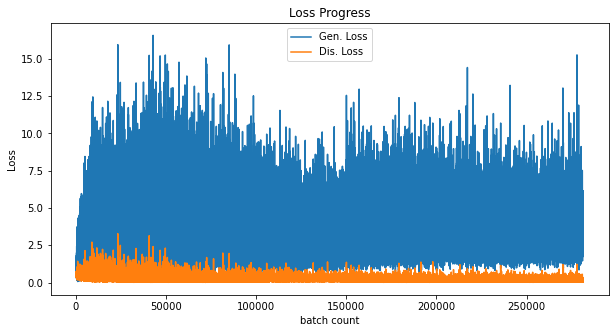

In [23]:
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100, device=device)
    img_fake = model_gen(fixed_noise).detach().cpu()
print(img_fake.shape)

torch.Size([16, 1, 28, 28])


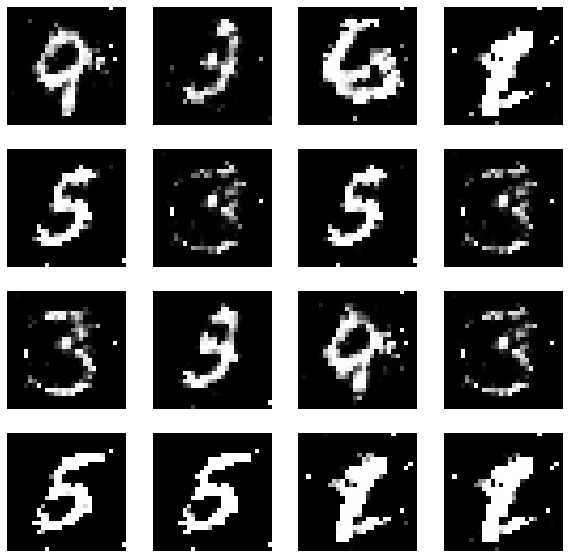

In [25]:
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5),cmap='gray')
    plt.axis('off')